In [1]:
# imports
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [2]:
df_energy_2020 = pd.read_csv('../data/prepared/df_energy_price_and_feeding_2020.csv')

In [3]:
df_energy_2020.head()

,datetime,nuclear_power,not_renewable,renewable,energy_price,date,day_of_week,time,total_energy_feeding
0,2020-01-01 00:00:00,8089.585,29700.989,14524.769,38.60,2020-01-01,Wednesday,00:00:00,52315.343
1,2020-01-01 00:15:00,8087.935,29597.398,14407.463,38.60,2020-01-01,Wednesday,00:15:00,52092.796
2,2020-01-01 00:30:00,8088.635,29433.049,14537.378,38.60,2020-01-01,Wednesday,00:30:00,52059.062
3,2020-01-01 00:45:00,8086.715,29319.558,14695.598,38.60,2020-01-01,Wednesday,00:45:00,52101.871
4,2020-01-01 01:00:00,8093.394,29202.803,14902.589,36.55,2020-01-01,Wednesday,01:00:00,52198.786


In [4]:
df_energy_2020.describe()

,nuclear_power,not_renewable,renewable,energy_price,total_energy_feeding
count,35136.000000,35136.000000,35136.000000,35136.000000,35136.000000
mean,6934.673246,33765.069651,27962.757734,30.471738,68662.500631
std,969.703507,11159.545300,12106.069379,17.501029,12388.070338
min,3739.551000,11985.471000,7809.697000,-83.940000,36223.006000
25%,6450.204500,25593.516000,18140.908750,21.750000,59317.419750
50%,6793.422000,32771.112000,26610.473500,30.990000,68732.337500
75%,7834.915000,39948.887250,36752.224000,40.250000,78088.085500
max,8185.779000,68966.183000,69026.970000,200.040000,99247.990000


#### what does it mean when the price is minus?

>Negative Strompreise (oder sehr niedrige Strompreise) kommen im Großhandel dann vor, wenn ein Stromüberschuss besteht. Oder anders gesagt, wenn die Stromerzeugung den Stromverbrauch überschreitet. Eine solche Situation entsteht unter anderem, bei einer sehr hohen Einspeisung mit sehr preisgünstigem Strom aus Wind, wie das im Moment der Fall ist.
[agrarheute](https://www.agrarheute.com/markt/diesel/strompreise-fallen-neue-tiefstaende-stromkunden-gehen-leer-602385)

In [5]:
df_energy_2020.loc[:,['nuclear_power', 'not_renewable', 'renewable', 'energy_price']].corr()

,nuclear_power,not_renewable,renewable,energy_price
nuclear_power,1.000000,0.407680,-0.135737,0.372776
not_renewable,0.407680,1.000000,-0.459684,0.796859
renewable,-0.135737,-0.459684,1.000000,-0.512600
energy_price,0.372776,0.796859,-0.512600,1.000000


### Analyzation - Day of week and Energy Price

In [6]:
# Name dataframe grouped by weekeday
grp_day_of_week = df_energy_2020.groupby(['day_of_week'])

In [7]:
list_day_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Energy price grouped by day_of_week
desc = grp_day_of_week['energy_price'].describe()
# Add a column Q3 - Q1
desc['QD'] = (desc['75%'] - desc['25%']) / 2
# create a series of median and rename column
median = grp_day_of_week['energy_price'].median()
median.rename('median', inplace=True)

# merge extended description and median 
desc_with_med_and_qd = pd.merge(desc, median, on='day_of_week')
desc_with_med_and_qd.reindex(index=list_day_of_week)

,count,mean,std,min,25%,50%,75%,max,QD,median
day_of_week,,,,,,,,,,
Monday,4992.0,32.391106,18.979678,-78.15,22.6125,33.365,43.2925,200.04,10.34000,33.365
Tuesday,4992.0,33.767548,18.152121,-83.94,24.2775,33.000,42.4600,189.25,9.09125,33.000
Wednesday,5088.0,35.137555,15.999207,-29.98,25.5375,33.785,43.2300,114.00,8.84625,33.785
Thursday,5088.0,35.097586,14.358696,-1.58,25.7650,34.040,43.1850,110.13,8.71000,34.040
Friday,4992.0,33.382268,13.440421,-8.77,24.9200,33.595,41.2525,106.35,8.16625,33.595
Saturday,4992.0,25.210457,12.838657,-11.16,17.1250,26.260,34.0000,58.00,8.43750,26.260
Sunday,4992.0,18.136963,20.075361,-74.97,7.5700,21.445,32.0100,58.97,12.22000,21.445


- Energy price on weekend are lower than on weekdays
- Mean and median are almost the same -> the prices are more or less evenly distributed from the lowest to highest price
- Standard deviation and Q3 - Q1 for this case??

<AxesSubplot: xlabel='day_of_week', ylabel='energy_price'>

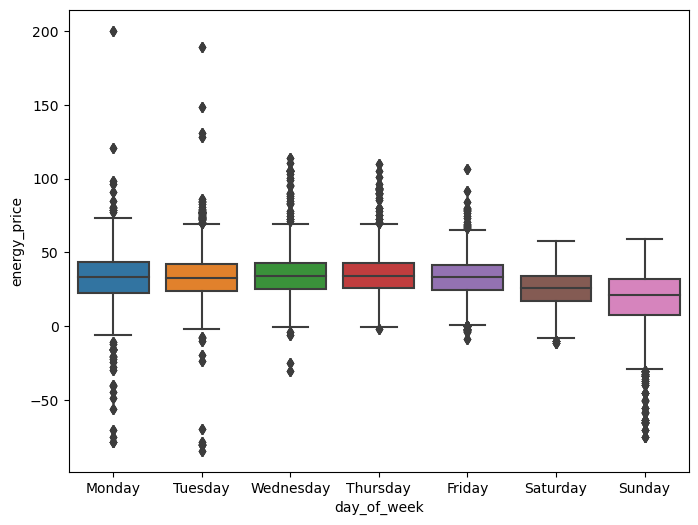

In [8]:
plt.figure(figsize=(8, 6))
sns.boxplot(
    x=df_energy_2020['day_of_week'], 
    order=list_day_of_week, 
    y=df_energy_2020['energy_price'] 
    )

- Monday and Tuesday have more outliers compared to the other weekdays -> Prediction for Monday and Tuesday would be more difficult than for other week days.
- Sunday has also relatively many outliers, but they are all lower than the average value
- Weekdays don't seem to have a crutial influence on the energy price.
- Energy price tends to decrease slightly on weekends.
- Energy price on Saturday seem to be most stable.

>Die Preisunterschiede an einem Tag sind unter der Woche stärker ausgeprägt als am Wochenende (einschließlich Feiertage). Von Montag bis Freitag liegen Höchst- und Tiefstpreise stärker auseinander als an Samstagen und Sonntagen. Der Grund dafür ist, dass viele Berufstätige am Wochenende nicht arbeiten und die Kinder zuhause sind. Wann dann etwa jede Familie morgens Kaffee oder Tee kocht, verteilt sich stärker über den Vormittag – an Wochentagen konzentriert sich das auf weniger Stunden am Morgen.
["Wann Du Strom verbrauchst, ist entscheidend für seinen Preis" - finanztip.de](https://www.finanztip.de/stromtarife/variable-stromtarife/)

### Analyzation -  Energy feeding volume and day of week

In [9]:
# add total energy feeding column
#? nuclear power included in not renewable energy?
df_energy_2020['total_energy_feeding'] = df_energy_2020['nuclear_power'] + df_energy_2020['not_renewable'] + df_energy_2020['renewable']

In [10]:
grp_day_of_week['total_energy_feeding'].describe()

,count,mean,std,min,25%,50%,75%,max
day_of_week,,,,,,,,
Friday,4992.0,69917.491386,12549.746954,42872.523,59873.86050,71069.7630,79565.27875,98751.726
Monday,4992.0,69918.247473,12239.264902,41207.345,60322.93700,70101.9400,79165.95925,98430.497
Saturday,4992.0,63356.519742,10602.921242,40311.080,54518.64850,64541.1690,71981.47675,85536.094
Sunday,4992.0,61656.717454,9854.759566,36223.006,53961.33400,62577.9965,68871.60650,87678.034
Thursday,5088.0,71422.509517,12226.575670,36914.398,61858.21525,71880.6695,81748.56975,98271.865
Tuesday,4992.0,72161.785827,12311.460898,44509.947,62091.98100,73424.3120,82150.08675,99247.990
Wednesday,5088.0,72085.332241,12017.922367,39435.459,62248.95900,73154.0215,81952.63625,97988.101


In [11]:
# reshape df_energy_2020
df_energy_2020_reshape = df_energy_2020.melt(['datetime', 'day_of_week', 'energy_price', 'date', 'time'], var_name='type_of_power', value_name='feeding_volume')

df_energy_2020_reshape.head()

,datetime,day_of_week,energy_price,date,time,type_of_power,feeding_volume
0,2020-01-01 00:00:00,Wednesday,38.60,2020-01-01,00:00:00,nuclear_power,8089.585
1,2020-01-01 00:15:00,Wednesday,38.60,2020-01-01,00:15:00,nuclear_power,8087.935
2,2020-01-01 00:30:00,Wednesday,38.60,2020-01-01,00:30:00,nuclear_power,8088.635
3,2020-01-01 00:45:00,Wednesday,38.60,2020-01-01,00:45:00,nuclear_power,8086.715
4,2020-01-01 01:00:00,Wednesday,36.55,2020-01-01,01:00:00,nuclear_power,8093.394


<AxesSubplot: xlabel='type_of_power', ylabel='feeding_volume'>

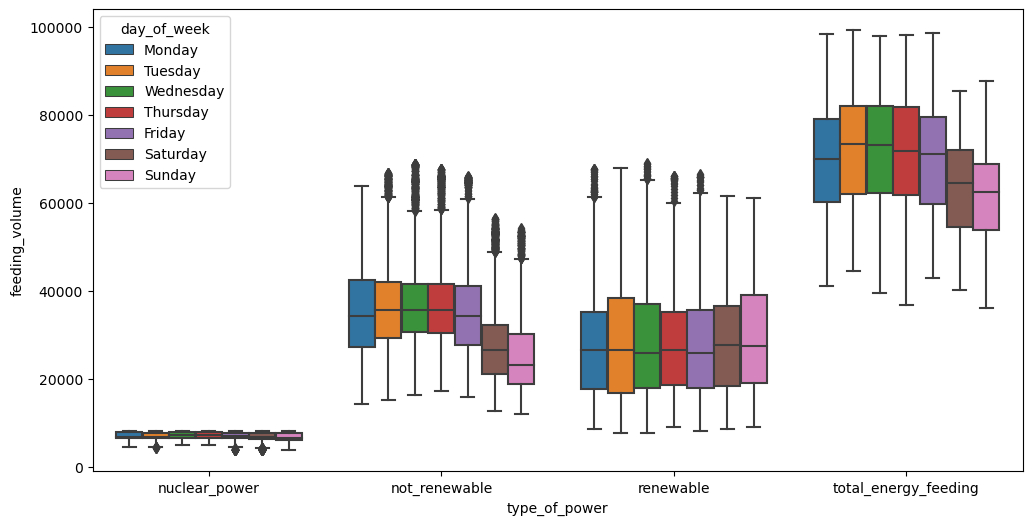

In [12]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_energy_2020_reshape,
    x='type_of_power',
    y='feeding_volume',
    hue='day_of_week',
    hue_order=list_day_of_week
)

- No significant differences on feeding volume of nuclear power and renewable energy per day of week
- Feeding volume of not renewable energy is considerably less (by about 10.000 MW)
--> Total feeding volume of renewable energy is the same also on weekends, but the demand is less (refer to the article above), so that the feeding volume of not renewable energy becomes lower, which leads to the lower price.

Ref:
[Bruttostromerzeugung in Deutschland 2019-2022](https://www.destatis.de/DE/Themen/Branchen-Unternehmen/Energie/Erzeugung/Tabellen/bruttostromerzeugung.html)

In [13]:
# wind_speed = m/s
# solar_radiation = W/m2
df_climate_2020 = pd.read_csv('../data/prepared/df_climate_2020.csv')
df_climate_2020

,datetime,wind_speed,solar_radiation
0,2020-01-01 00:00:00,2.4,0
1,2020-01-01 01:00:00,2.4,0
2,2020-01-01 02:00:00,2.5,0
3,2020-01-01 03:00:00,2.4,0
4,2020-01-01 04:00:00,2.4,0
...,...,...,...
8779,2020-12-31 19:00:00,2.8,0
8780,2020-12-31 20:00:00,2.8,0
8781,2020-12-31 21:00:00,2.7,0
8782,2020-12-31 22:00:00,2.6,0


## Combine energy data and climate data

In [14]:
# resample df_energy_2020 by hour, as climate data is per hour

# convert to datetime
df_energy_2020['datetime'] = pd.to_datetime(df_energy_2020['datetime'])

df_energy_2020_per_hour = df_energy_2020.resample('60min', on='datetime').agg({
    'nuclear_power': 'mean', 
    'not_renewable': 'mean',
    'renewable': 'mean',
    'energy_price': 'mean'
    })
df_energy_2020_per_hour.reset_index(inplace=True)
df_energy_2020_per_hour.head()

,datetime,nuclear_power,not_renewable,renewable,energy_price
0,2020-01-01 00:00:00,8088.21750,29512.74850,14541.30200,38.60
1,2020-01-01 01:00:00,8081.15875,29178.66275,14949.45575,36.55
2,2020-01-01 02:00:00,8071.44750,29414.36225,15077.92500,32.32
3,2020-01-01 03:00:00,8072.27750,29365.12575,15307.22725,30.85
4,2020-01-01 04:00:00,8068.91550,29436.37500,15320.25825,30.14


In [15]:
# datetime
df_climate_2020['datetime'] = pd.to_datetime(df_climate_2020['datetime'])

In [16]:
df_energy_climate_2020 = pd.merge(df_climate_2020, df_energy_2020_per_hour)
df_energy_climate_2020.head()

,datetime,wind_speed,solar_radiation,nuclear_power,not_renewable,renewable,energy_price
0,2020-01-01 00:00:00,2.4,0,8088.21750,29512.74850,14541.30200,38.60
1,2020-01-01 01:00:00,2.4,0,8081.15875,29178.66275,14949.45575,36.55
2,2020-01-01 02:00:00,2.5,0,8071.44750,29414.36225,15077.92500,32.32
3,2020-01-01 03:00:00,2.4,0,8072.27750,29365.12575,15307.22725,30.85
4,2020-01-01 04:00:00,2.4,0,8068.91550,29436.37500,15320.25825,30.14


## Correlation of energy and climate
- wind speed and renewable energy have high correlation
- wind speed and energy price have negative correlation

In [17]:
df_energy_climate_2020.corr(numeric_only=True)

,wind_speed,solar_radiation,nuclear_power,not_renewable,renewable,energy_price
wind_speed,1.000000,0.096488,-0.050952,-0.379269,0.804260,-0.444114
solar_radiation,0.096488,1.000000,-0.254697,-0.186633,0.478710,-0.216114
nuclear_power,-0.050952,-0.254697,1.000000,0.407899,-0.135583,0.373059
not_renewable,-0.379269,-0.186633,0.407899,1.000000,-0.460238,0.797350
renewable,0.804260,0.478710,-0.135583,-0.460238,1.000000,-0.513584
energy_price,-0.444114,-0.216114,0.373059,0.797350,-0.513584,1.000000


In [18]:
# imports
from matplotlib import cm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as ticker
%matplotlib inline

In [19]:
# resample the combined df by month
df_energy_climate_2020.set_index('datetime', inplace=True)
df_energy_climate_per_month_2020 = df_energy_climate_2020.resample('M').mean()
df_energy_climate_per_month_2020.reset_index(inplace=True)

In [20]:
df_energy_climate_per_month_2020['month_year'] = df_energy_climate_per_month_2020['datetime'].dt.to_period('M')
df_energy_climate_per_month_2020

,datetime,wind_speed,solar_radiation,nuclear_power,not_renewable,renewable,energy_price,month_year
0,2020-01-31,4.155108,34.024194,7807.641693,40108.081534,30550.649508,34.978710,2020-01
1,2020-02-29,5.970690,56.419540,7419.751695,29840.861220,39375.945443,21.911839,2020-02
2,2020-03-31,4.426747,131.969086,7266.131540,31178.614326,32605.582938,22.519315,2020-03
3,2020-04-30,3.495417,229.087500,6561.627329,24050.886692,29070.825843,17.049194,2020-04
4,2020-05-31,3.361694,234.065860,5762.919882,24769.446723,27092.300725,17.604879,2020-05
5,2020-06-30,3.197083,230.220833,6463.409776,29899.843443,24925.065740,26.229167,2020-06
6,2020-07-31,3.185484,235.129032,5687.576221,30833.884795,26203.010712,30.074946,2020-07
7,2020-08-31,2.995833,200.256720,7521.303469,34069.302622,24342.192233,34.889704,2020-08
8,2020-09-30,2.827222,153.597222,7349.898565,37079.136104,23241.985196,43.678097,2020-09
9,2020-10-31,3.853629,67.380376,6892.146856,36540.185486,29493.414200,33.955901,2020-10


In [26]:
month_list = df_energy_climate_per_month_2020['month_year'].dt.strftime("%Y-%m").to_list()

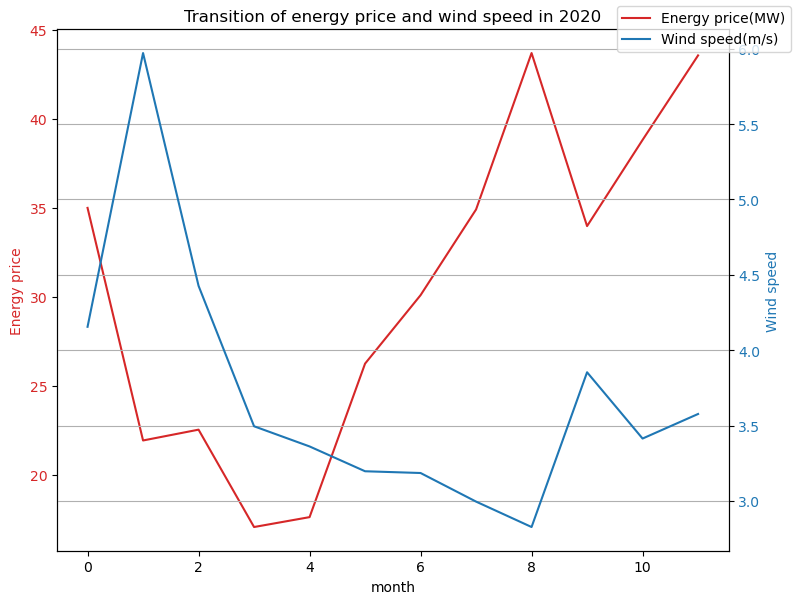

In [32]:
# plot energy price and wind speed in one graph
fig, ax1 = plt.subplots(figsize=(8, 6))

# energy_price
color_1 = 'tab:red'
ax1.set_xlabel('month')
ax1.set_ylabel('Energy price', color=color_1)
ax1.plot(
    # methode nachschauen - matplotlib / pandas
    df_energy_climate_per_month_2020['energy_price'],
    color=color_1
)

# #? xticklabels wrong
# ax1.set_xticklabels(
#     df_energy_climate_per_month_2020['month_year'], 
#     rotation=45
# )

# wind_speed
ax2 = ax1.twinx()
color_2 = 'tab:blue'
ax2.set_ylabel('Wind speed', color=color_2)
ax2.plot(
    df_energy_climate_per_month_2020['wind_speed'],
    color=color_2
)

# change label color
ax1.tick_params(axis='y', labelcolor=color_1)
ax2.tick_params(axis='y', labelcolor=color_2)

# rotate x-axis
ax2.tick_params(axis='x', rotation=45)

# adjust subplot params so that the subplots fits in to the figure area
fig.tight_layout()

plt.grid()
plt.title('Transition of energy price and wind speed in 2020')
fig.legend(['Energy price(MW)', 'Wind speed(m/s)'])
plt.show()

- Price reduction from April to May although wind speed is not high (incident in the period: first corona-lockdown in Germany in March)

## Time series analysis

In [50]:
# difference
df_energy_climate_2020['energy_price_diff'] = df_energy_climate_2020['energy_price'].diff()

# difference in percentage
df_energy_climate_2020['energy_price_diff_pct'] = df_energy_climate_2020['energy_price'].pct_change()

# moving average
df_energy_climate_2020['energy_price_moving_avg'] = df_energy_climate_2020['energy_price'].rolling(3, min_periods=1).mean()


df_energy_climate_2020['energy_price_moving_avg'].head(10)

datetime
2020-01-01 00:00:00    38.600000
2020-01-01 01:00:00    37.575000
2020-01-01 02:00:00    35.823333
2020-01-01 03:00:00    33.240000
2020-01-01 04:00:00    31.103333
2020-01-01 05:00:00    30.386667
2020-01-01 06:00:00    30.103333
2020-01-01 07:00:00    30.273333
2020-01-01 08:00:00    30.433333
2020-01-01 09:00:00    30.523333
Name: energy_price_moving_avg, dtype: float64

In [46]:
# check correlation with energy_price shifted one day later
df_energy_climate_2020['energy_price_shift'] = df_energy_climate_2020['energy_price'].shift()

df_energy_climate_2020.corr(numeric_only=True)

,wind_speed,solar_radiation,nuclear_power,not_renewable,renewable,energy_price,energy_price_diff,energy_price_diff_pct,energy_price_shift
wind_speed,1.000000,0.096488,-0.050952,-0.379269,0.804260,-0.444114,0.057136,0.031028,-0.462998
solar_radiation,0.096488,1.000000,-0.254697,-0.186633,0.478710,-0.216114,-0.012361,-0.025255,-0.212017
nuclear_power,-0.050952,-0.254697,1.000000,0.407899,-0.135583,0.373059,0.008674,0.000301,0.370190
not_renewable,-0.379269,-0.186633,0.407899,1.000000,-0.460238,0.797350,0.029841,-0.004245,0.787579
renewable,0.804260,0.478710,-0.135583,-0.460238,1.000000,-0.513584,-0.060192,0.000382,-0.493715
energy_price,-0.444114,-0.216114,0.373059,0.797350,-0.513584,1.000000,0.165374,0.017544,0.945429
energy_price_diff,0.057136,-0.012361,0.008674,0.029841,-0.060192,0.165374,1.000000,0.099069,-0.164991
energy_price_diff_pct,0.031028,-0.025255,0.000301,-0.004245,0.000382,0.017544,0.099069,1.000000,-0.015203
energy_price_shift,-0.462998,-0.212017,0.370190,0.787579,-0.493715,0.945429,-0.164991,-0.015203,1.000000


## Auto correlation

In [34]:
import statsmodels.api as sm

In [76]:
df_energy_2021 = pd.read_csv('../data/prepared/df_energy_price_and_feeding_2021.csv')
df_energy_2021

,datetime,nuclear_power,not_renewable,renewable,energy_price,date,day_of_week,time,total_energy_feeding
0,2021-01-01 00:00:00,8151.120,35141.305,11491.710,48.19,2021-01-01,Friday,00:00:00,54784.135
1,2021-01-01 00:15:00,8147.209,34875.902,11331.250,48.19,2021-01-01,Friday,00:15:00,54354.361
2,2021-01-01 00:30:00,8154.020,34825.553,11179.375,48.19,2021-01-01,Friday,00:30:00,54158.948
3,2021-01-01 00:45:00,8152.820,34889.110,11072.377,48.19,2021-01-01,Friday,00:45:00,54114.307
4,2021-01-01 01:00:00,8156.530,34922.123,10955.356,44.68,2021-01-01,Friday,01:00:00,54034.009
...,...,...,...,...,...,...,...,...,...
35035,2021-12-31 22:45:00,3131.990,15496.499,38359.152,6.32,2021-12-31,Friday,22:45:00,56987.641
35036,2021-12-31 23:00:00,3208.357,15581.937,38315.563,50.05,2021-12-31,Friday,23:00:00,57105.857
35037,2021-12-31 23:15:00,3325.018,15834.187,38115.888,50.05,2021-12-31,Friday,23:15:00,57275.093
35038,2021-12-31 23:30:00,3344.329,15776.516,37617.026,50.05,2021-12-31,Friday,23:30:00,56737.871


In [78]:
df_energy_2020_2021 = pd.concat([df_energy_2020, df_energy_2021])

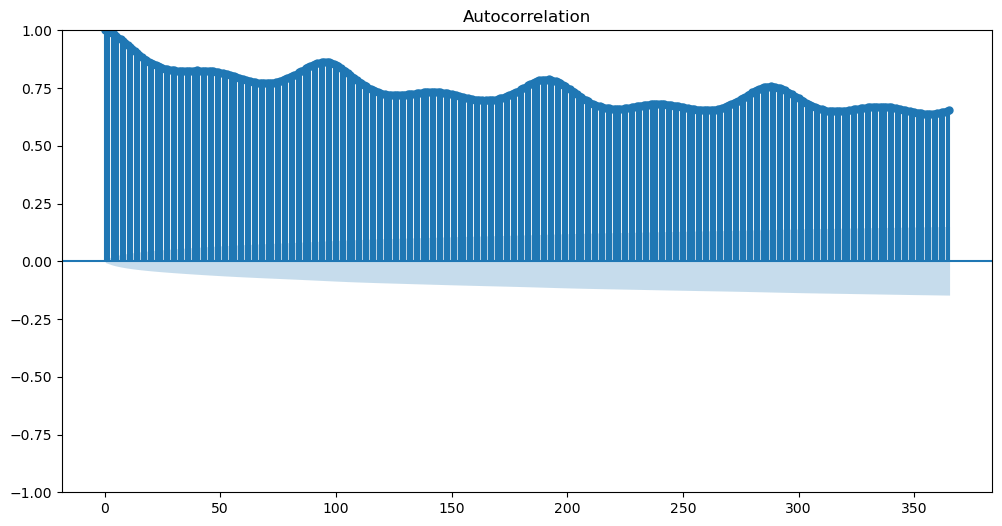

In [79]:
plt.rc('figure', figsize=(12,6))
res = sm.graphics.tsa.plot_acf(df_energy_2020_2021['energy_price'], lags=365)

In [81]:
sm.tsa.stattools.acf(df_energy_2020_2021['energy_price'], nlags=365)

array([1.        , 0.99601557, 0.99203114, 0.98804671, 0.98406227,
       0.97639677, 0.96873126, 0.96106576, 0.95340026, 0.94444599,
       0.93549172, 0.92653745, 0.91758319, 0.90923298, 0.90088277,
       0.89253257, 0.88418236, 0.87753673, 0.87089109, 0.86424545,
       0.85759981, 0.85297691, 0.84835401, 0.84373111, 0.8391082 ,
       0.83654675, 0.83398531, 0.83142386, 0.82886241, 0.82777524,
       0.82668807, 0.8256009 , 0.82451373, 0.82448398, 0.82445422,
       0.82442447, 0.82439471, 0.82477199, 0.82514927, 0.82552654,
       0.82590382, 0.82582784, 0.82575185, 0.82567587, 0.82559988,
       0.8245132 , 0.82342651, 0.82233983, 0.82125314, 0.81915737,
       0.8170616 , 0.81496583, 0.81287005, 0.80982192, 0.80677378,
       0.80372564, 0.8006775 , 0.7974136 , 0.7941497 , 0.79088579,
       0.78762189, 0.78489336, 0.78216483, 0.77943631, 0.77670778,
       0.77528238, 0.77385699, 0.77243159, 0.7710062 , 0.77117925,
       0.77135231, 0.77152537, 0.77169842, 0.77384671, 0.77599

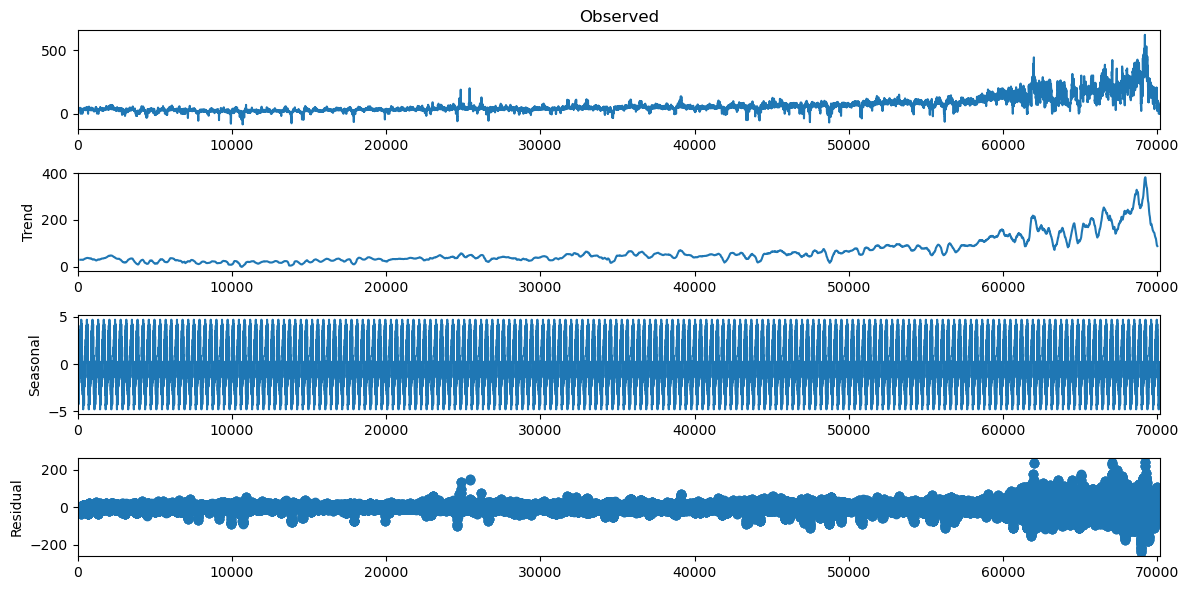

In [83]:
trends = sm.tsa.seasonal_decompose(df_energy_2020_2021['energy_price'].values, period=365).plot()

## Exponential Smoothing

#### Holt-Winters model
- has Trend
- has Seasonality
- Not random

In [ ]:
# Exponential smoothing
sr_exp_smoothing = df_energy_2020.copy()
sr_exp_smoothing.set_index('datetime', inplace=True)
# resample the data - take day as unit(use mean value)
sr_exp_smoothing = sr_exp_smoothing['energy_price'].resample(rule='D').mean()

In [ ]:
# set figure size
rcParams['figure.figsize'] = 8,6
# plot
sr_exp_smoothing.plot()

In [ ]:
# Build a model
model = ExponentialSmoothing(endog=sr_exp_smoothing).fit()

In [ ]:
# create prediction for 60 days
predictions = model.forecast(60)

In [ ]:
# set figure size
sr_exp_smoothing.plot(figsize = (8, 6))
# Plot predictions
predictions.plot()